# Event Generator for Thermal Photon Scattering

In [20]:
import matplotlib.pyplot as plt 
import numpy as np
import math
import random as rnd
from os.path import expanduser
from IPython.core.display import display, HTML

%reload_ext autoreload
%cd ~/Python/FCCee-Synchrotron-Radiation/source/
import Tools as Tls
from BeamGen import Beam
import VisualSpecs


display(HTML("<style>.container { width:100% !important; }</style>"))

# set print ouptut to 16 digits
np.set_printoptions(formatter={'float': lambda x: "{0:0.16f}".format(x)})

home = expanduser('~')
labels = ['E', '$p_x$', '$p_y$', '$p_z$']

m0 = 511e-6
stats = 1e5
plotPath = '/tmp/'
pc = 182.50 # GeV/c
Eb = np.sqrt(pc**2 - (m0)**2)
HalfCross = 0.015
LrntzF = Eb/m0
T = 296.15 # 0° -- 273.15 K
beta = np.sqrt(1 - 1/LrntzF**2)
print(" ------------- \n beam energy = ", Eb, "GeV \n m0 = ", m0, "\n gamma = ", LrntzF, "\n beta =", beta, "\n Npart =", stats, "\n -------------")

def fourMom2( vec ):
    return vec[0]**2 - vec[1]**2 - vec[2]**2 - vec[3]**2

def RotFrmZ( theta, phi ):
    return np.array([[1, 0, 0, 0],
                     [0, np.cos(theta)*np.cos(phi), -np.sin(phi), np.cos(phi)*np.sin(theta)],
                     [0, np.cos(theta)*np.sin(phi), np.cos(phi), np.sin(theta)*np.sin(phi)],
                     [0, -np.sin(theta), 0, np.cos(theta)]])

def RotToZ( theta, phi ):
    return np.array([ [1, 0, 0, 0],
                      [0, np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)],
                      [0, -np.sin(phi), np.cos(phi), 0],
                      [0, np.cos(phi)*np.sin(theta), np.sin(theta)*np.sin(phi), np.cos(theta)] ])

def getRotVec3(vec, verbose = 0):
    cost = vec[2]; theta = np.arccos(cost); sint = np.sin(theta) # np.sqrt(1 - cost**2); 
    if verbose: print('cost = ', cost, '--> theta =', theta)
    
    # only crosscheck
    if verbose: 
        print('sint =', sint, '--> theta =', np.arcsin(sint), ' --> theta =', np.sin(theta))

    sinphi = vec[1]/sint; phi = np.arcsin(sinphi) 
    cosphi = vec[0]/sint;
#     if verbose: print('cosphi =', cosphi, '--> phi =', np.arccos(cosphi))
    if verbose: print('sinphi =', sinphi, '--> phi =', np.arcsin(sinphi))
    # only crosscheck
    if verbose: 
#         sinphi = vec[1]/sint;
#         print('sinphi =', sinphi, '--> phi =', np.arcsin(sinphi)) 
        print('cosphi =', cosphi, '--> phi =', np.arccos(cosphi)) 

    return theta, phi

/home/nikita/Python/FCCee-Synchrotron-Radiation/source


 ------------- 
 beam energy =  182.4999999992846 GeV 
 m0 =  0.000511 
 gamma =  357142.85714145715 
 beta = 0.99999999999608 
 Npart = 100000.0 
 -------------


## 0. Initial Particles

### 0.1 Generate initial Electron
The initial electrons are beam particles, therfore might be Gaussian distributed with an average energy of $E_b$. This distribution has to be based on the emittance of the beam, $\epsilon_{x,y}$. Generate Gaussains for x,x' and y,y'?

The electron four momentum can be written as $$ q_p = (E,\mathbf{p}) = \begin{bmatrix} E/c \\ p_x \\ p_y \\ p_z \end{bmatrix} $$
Where $p_x$ and $p_y$ can be randomly generated using a Gaussian centered at 0, with a spread based on the emittance: $\mu = 0, \sigma = \sigma_{x,y} $

The beam generator below generates the random distributions and returns the vector `dir_EU` for a given set of particles

In [21]:
# electrons are taken from the beam. Gaussian distribution based on emittances
b1 = Beam(home + '/Codes/Projects/FCC-ee-lattice/MadX/output/fcc_ee_b1.dat', home + '/Codes/Projects/FCC-ee-lattice/MadX/output/fcc_ee_b1_twiss.tfs', 'TestBeam', stats, HalfCross, pc, verbose = 0)
b1.set_gauss(plotPath)
p_e = b1.gen_BeamMom('QC1L3.2'); 

# generate beam energy based on normal distribution (2% acceptance)
Ebeam = b1.gen_BeamEnergy(pc, 0.02*pc)
# Gamm = np.array( [enrg/m0 for enrg in Ebeam] )
# Bet = np.array( [np.sqrt(1 - 1/gam**2) for gam in Gamm] )
Gamm = Ebeam/m0
Bet = np.sqrt(1 - 1/Gamm**2)

# calculate momentum (energy - restmass)
Pbeam = np.sqrt( Ebeam**2 - m0**2 )

# build incoming electron four-momentum
qe_in = np.array( [ np.array([enrg, pbem*vec[0], pbem*vec[1], pbem*vec[2]]) for vec,enrg,pbem in zip(p_e,Ebeam,Pbeam)], dtype = float )
# qe_in2= [ fourMom2(vec) for vec in qe_in]

# # some visualization
# axs = Tls.sbplSetUp(4)
# for j in range(0,4):
#     axs[j].hist([mom[j] for mom in qe_in], bins = 100)
#     axs[j].set_xlabel(labels[j])
# plt.tight_layout()

print(len(p_e))

/home/nikita/Python/FCCee-Synchrotron-Radiation/source/TfsTables.py:20: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pd.read_table(self.tfs, sep = r'\s+', comment = '@', index_col = False, converters = {'NAME':str, 'KEYWORD':str})
/opt/miniconda/miniconda2/envs/mdi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/nikita/Python/FCCee-Synchrotron-Radiation/source/TfsTables.py:35: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datet

100000


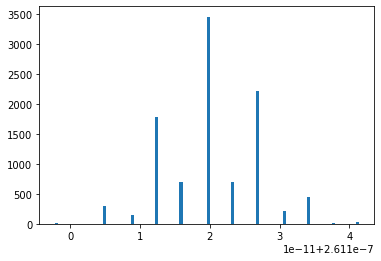

In [22]:
plt.hist(qe_in2, bins=100);

### 0.2 Rotate the beam in z direction
Assuming a general vector can be represented as $$ \mathbf{r} = \begin{bmatrix} \sin\theta\cos\phi \\ \sin\theta\sin\phi \\ \cos\theta \end{bmatrix}, $$ allows to reconstruct the angles $\theta$ and $\phi$ according to $$ \begin{align} \cos\theta &= r_z \\ \cos\phi &= \frac{r_x}{\sin\theta} \\ \sin\phi &= \frac{r_y}{\sin\theta} \end{align}. $$ 
Where $\sin\theta = \sqrt{1 - \cos^2\theta} $. Using these angles, `RotToZ` is applied on the incoming electron and the photon as well (aka rotation of reference system).

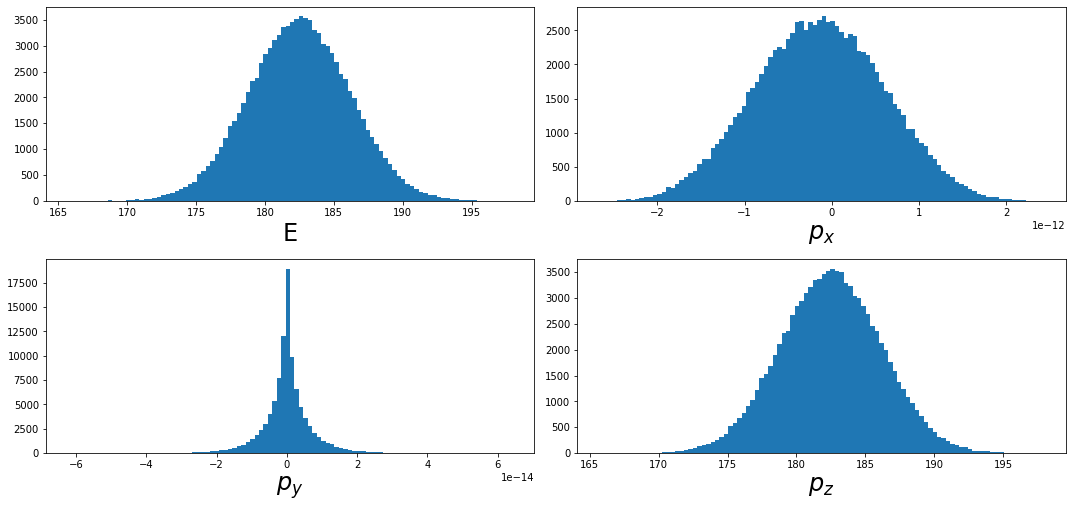

In [23]:
angles_qe = np.array( [getRotVec3(vec) for vec in p_e] )

qe_in_z = np.array([RotToZ(ang[0], ang[1]) @ vec for vec,ang in zip(qe_in,angles_qe)])

# some visualization
axs = Tls.sbplSetUp(4)
for j in range(0,4):
    axs[j].hist([mom[j] for mom in qe_in_z], bins = 100)
    axs[j].set_xlabel(labels[j])
plt.tight_layout()

# print(qe_in_z)

### 0.2 Generate the Planck Spectrum
Photon energies for inverse Compton scattering are generated following the Plack spectrum. Approximate the distribution $$ \frac{x^2}{e^x - 1} $$ with three separate, simple and invertible functions, 
$$ \begin{align} f_1(x) &= x \\ f_2(x) &= c \\ f_3(x) &= e^{a + b*x} \end{align}. $$
These are applied on three intervals, $$ \begin{align} 0 &\rightarrow x_1 \\ x_1 &\rightarrow x_2 \\ x_2 &\rightarrow \infty \end{align}. $$
In order to distinguish the intervals, probablilites such as $P_{12} = \frac{I_1}{I_1 + I_2 + I_3}$ and $P_{23} = \frac{I_1 + I_2}{I_1 + I_2 + I_3}$are used, with the integrals $$ \begin{align} I_1 &= \int_0^c dx x \\ I_2 &= \int_c^d dx c \\ I_3 &= \int_d^\infty dx e^{a + bx} \end{align} $$

Constants a,b and c are known (ref) to be 1.266, -0.6 and 0.648, respectively. d is chosen such that $d = \frac{log(c) -a }{b}.$ 
In order to cover the whole interval, a mapping is used on a given random value $r$ (generated on 0,1) out to infinity, using a log: $$ x_1\sqrt{r} \\ x_1 + (x_2 - x_1)r \\ x_2 + log(r)/b$$



/opt/miniconda/miniconda2/envs/mdi/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


100000


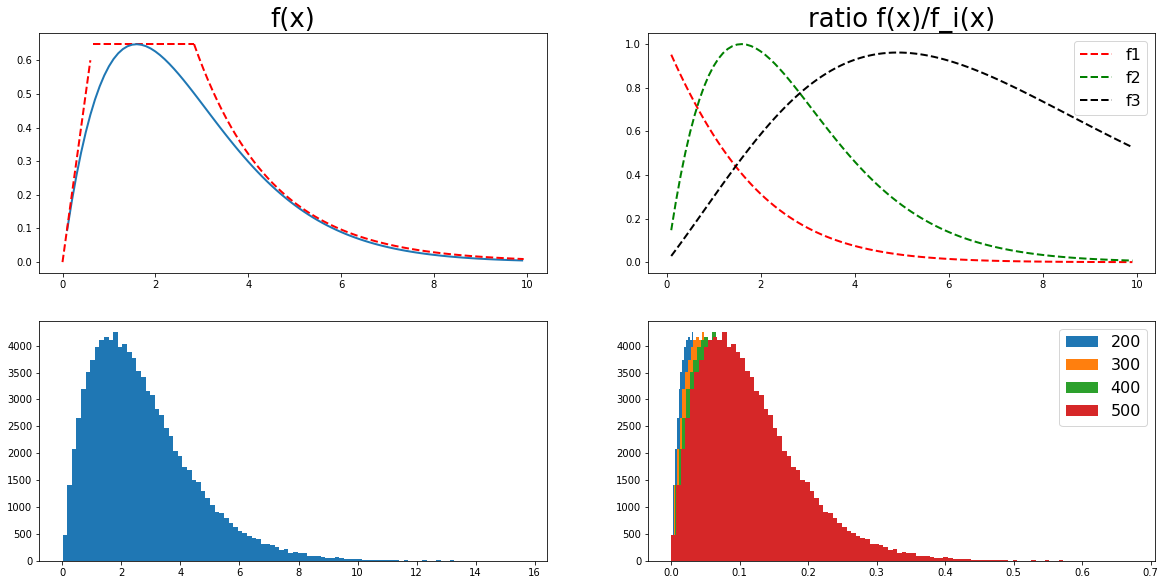

In [24]:
axs = Tls.sbplSetUp(4, [20,15])

# define some constants
k = 8.617e-5 # given in eV/K
TempRange = [200, 300, 400, 500]
c = .648; a = 1.266; b = -.6

def f(x):
    return x**2/(np.exp(x) - 1)
def dnP(x):
    return x**2/(np.exp(x) - 1)

def f1(x):
    return x
def f2():
    return c
def f3(x):
    return np.exp(a + b*x)

def genPlanck( stats, a, b, c):
    
    # define interval boundaries
    x1 = c; x2 = (np.log(c) - a)/b; xDiff = x2 - x1

    # basically solutions to the integrals I_1 to I_3
    p1 = x1*x1/2; p2 = x1*xDiff; p3 = -1/b*np.exp(a + b*x2)
    P12 = p1/(p1+p2+p3); P23 = (p1+p2)/(p1+p2+p3)

    values = []; i = 0
    while i < stats:

        # generate a couple of random numbers on (0,1)
        r1 = np.random.uniform(0,1)
        r2 = np.random.uniform(0,1)
        r3 = np.random.uniform(0,1)


        # choose which function to use, based on interval
        if r1 < P12: 
            w = x1*np.sqrt(r2)
            if w > (np.exp(w) - 1)*r3: 
                values.append(w)
                i += 1 
        elif r1 < P23: 
            w = x1 + xDiff*r2
            if w**2 > x1*(np.exp(w) - 1)*r3: 
                values.append(w)
                i += 1
        else: 
            w = x2 + np.log(r2)/b
            if w**2 > (np.exp(w) - 1)*np.exp(a + b*w)*r3: 
                values.append(w)
                i += 1
        
    return values

    
xrange = np.arange(0,10, .1)
intrvl1 = np.arange(0,c,.1)
intrvl3 = np.arange((np.log(c) - a)/b, 10, .1)

axs[0].plot(xrange, f(xrange)); axs[0].set_title('f(x)')

axs[1].plot(xrange, f(xrange)/f1(xrange), color = 'r', ls = '--', label = 'f1')
axs[1].plot(xrange, f(xrange)/f2(), color = 'g', ls = '--', label = 'f2')
axs[1].plot(xrange, f(xrange)/f3(xrange), color = 'k', ls = '--', label = 'f3')
axs[1].legend(); axs[1].set_title('ratio f(x)/f_i(x)')

photEnrg = genPlanck( stats, a, b, c)
axs[2].hist( photEnrg, bins = 100 );

axs[0].plot(intrvl1, f1(intrvl1), color = 'r', ls = '--')
axs[0].hlines(c, c, (np.log(c) - a)/b, colors = 'r', linestyles = '--')
axs[0].plot(intrvl3, f3(intrvl3), color = 'r', ls = '--');

for temp in TempRange:
    energ = [ k*temp*val for val in photEnrg]
    axs[3].hist( energ, bins = 100, label = '%i' %temp)
axs[3].legend();
print(len(photEnrg))

### 0.3 Initial Photon Energies
With the generator established above, photon energies can be generated by multiplication with $kT$. Assuming a temperature of $23^\circ$C, the distribution has a mean around 0.7 eV, as expected for this temperature regime. 

100000 [0.0000000000367620 0.0000000000366265 0.0000000000741293 ...
 0.0000000001180837 0.0000000000760249 0.0000000001634929]


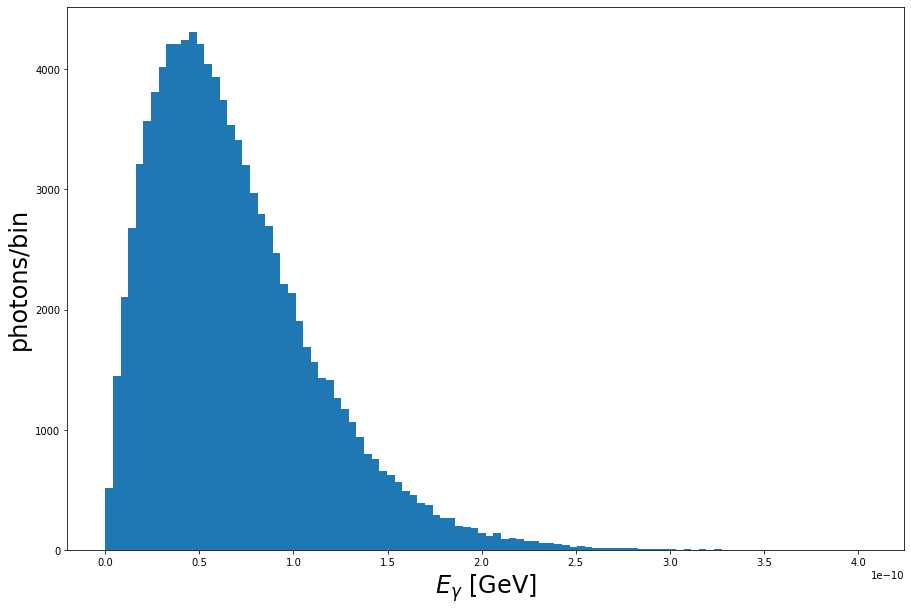

In [25]:
# provide the energies for the photons
values = genPlanck(stats, a, b, c)
Ei = np.array( [k*T*val/1e9 for val in values] )
# Ei = 
plt.figure( figsize = (15,10) )
plt.hist( Ei, bins = 100 );
plt.xlabel('$E_\\gamma$ [GeV]'); plt.ylabel('photons/bin');
print(len(Ei), Ei)

### 0.4 Generate initial photon four momentum
The photon energies should follow the distribution of the Planck spectrum for black body radiation:
$$ dn_P = \frac{\epsilon^2d\epsilon}{\pi^2(c\hbar)^3\left(e^{\frac{\epsilon}{k_BT}} - 1\right)} $$

This distribution will be used with a temperature of $T \approx 300 K$ (given the experience from LEP). With a given density $\rho_\gamma$, the average photon energy can be expressed as $E_\gamma = 2.7kT\approx0.069$ eV.

The photon 4-momentum is based on $E = pc \equiv\epsilon_i$ since the photon is massless. Hence, the momentum itself is given in $\epsilon_i/c$. The four vector, on the other hand, can be written as $$ q_k = (\epsilon_i, \mathbf{p}) = \begin{bmatrix} \epsilon_i/c \\ \epsilon_i v_x/c \\ \epsilon_i v_y/c \\ \epsilon_i v_z/c \end{bmatrix} = \begin{bmatrix} p^t \\ p^x \\ p^y \\ p^z \end{bmatrix}$$
Where $ v_x^2 + v_y^2 + v_z^2 = c^2 \equiv 1$.

Photons need to be generated based on the spectrum above, with random directions in space. Considering the spatial angle, $d\Omega = d\cos\theta d\phi$, generate $\cos\theta$ on $[-1.,1]$ and $\phi$ on $[0,2\pi]$. The four vector is established on spacial transformations using both angles: $$ x = \sin\theta\cos\phi \\ y = \sin\theta\sin\phi \\ z = \cos\theta $$
which results in an isotropic distribution in space.



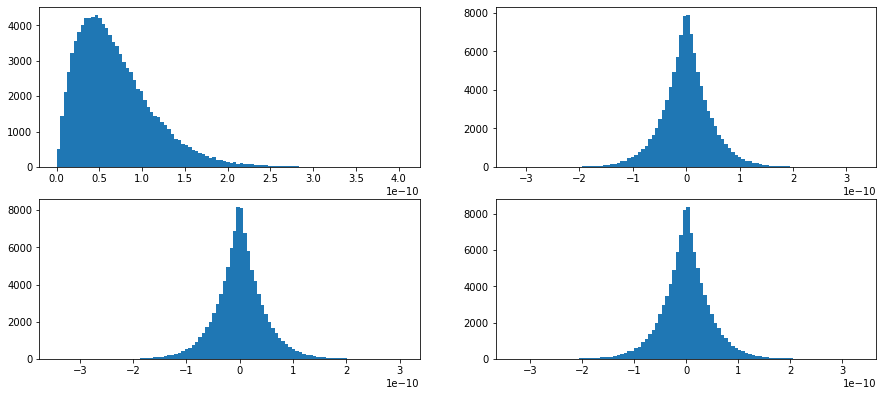

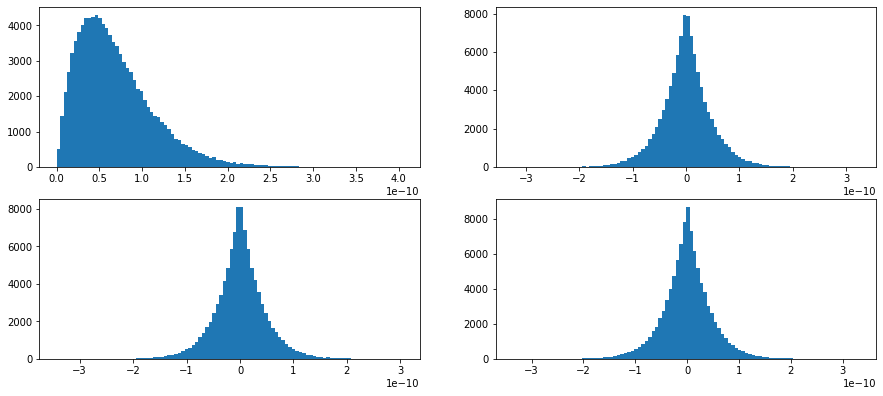

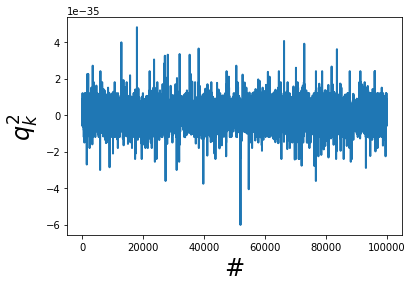

In [26]:
# generate cosPsi, sinPsi and phi
#
CosPsi = np.array([np.random.uniform(-1,1) for i in range(int(stats))])
SinPsi = np.array([np.sqrt(1 - cos**2) for cos in CosPsi])
Phi = np.array([np.random.uniform(0,2*np.pi) for i in range(int(stats))])

# construct incoming photon four momentum and roate by same amount as qp_e_in
qk_in = np.array([np.array([val, val*np.cos(phi)*sinPsi, val*sinPsi*np.sin(phi), val*cosPsi ]) for val, sinPsi, cosPsi, phi in zip(Ei, SinPsi, CosPsi, Phi)])
qk_in_z = np.array([ RotToZ(ang[0], ang[1]) @ qk for qk,ang in zip(qk_in, angles_qe)])
qk2 = [ fourMom2(qkz) for qkz in qk_in_z ]
# some visualization
#
axs = Tls.sbplSetUp(4)
for j in range(4):
    axs[j].hist( [vec[j] for vec in qk_in], bins = 100 );
axs1 = Tls.sbplSetUp(4)
for j in range(4):
    axs1[j].hist( [vec[j] for vec in qk_in_z], bins = 100)
#print(qk_in, '\n', qe_in_z, '\n', qk_in_z)

plt.figure(); plt.plot( qk2 ); plt.xlabel('#'); plt.ylabel('$q_k^2$');

## 1. Electron Rest Frame - 1st Boost
Photon Energies need to transformed into the electron rest frame, using a Lorentz boost. The electron four momentum becomes $$ q_e^* = \begin{bmatrix} m_0 \\ 0 \\ 0 \\ 0 \end{bmatrix} $$

As for the photon, a Lorentz boost in x direction can be expressed using the following matrix representation:
$$ \begin{bmatrix} \gamma & -\beta\gamma & 0 & 0 \\ -\beta\gamma & \gamma & 0 & 0 \\  0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix} $$
Which results in the photon four-momentum as $$ q_k^* = \begin{bmatrix} \gamma(\epsilon_i  - \beta p_x) \\ \gamma(p_x - \epsilon_i) \\ p_y \\ p_z  \end{bmatrix} $$
A further assumption may be $\beta\approx1$.
Lorentz invariants can be used for an internal check. These invariants are the mass $m$ and the four-momentum square $\mathbf{p}^2$

**Try to boost only the energy and look at the spectrum after the boost**

(0, 4e-05)

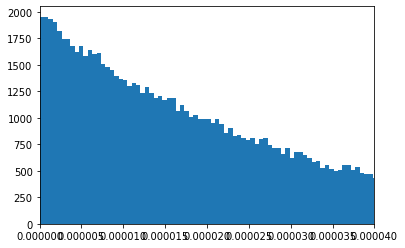

In [27]:
# photon four momenta given as phtMmtZ
# define LT
def Boost( gam, bet ):
    return np.array( [ [gam, 0, 0, -beta*gam],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [-beta*gam, 0, 0, gam] ] )

# boost into e-rest frame
testEprim = np.array( [[gam*vec[0] - gam*bet*vec[3]] for gam, bet, vec in zip(Gamm, Bet, qk_in_z)] )
# qkstar = np.array( [Boost( gam, bet) @ qk for gam,bet,qk in zip(Gamm,Bet, qk_in_z) ] )
# pk_star = np.array( [np.array([vec[1], vec[2], vec[3]]) for vec in qkstar] )
# qestar = np.array( [Boost( gam, bet) @ qe for gam, bet, qe in zip(Gamm, Bet, qe_in_z) ] )

# qkst2 = [ fourMom2(qkst) for qkst in qkstar ]
# qest2 = [ fourMom2(qest) for qest in qestar ]
# pk_star
# angles_from_z = [getRotVec3(pk) for pk in pk_star]

# # some visualization
# #
# axs = Tls.sbplSetUp(4, [10, 15])
# for j in range(0,4):
#     axs[j].hist( [vec[j] for vec in qkstar], bins = 100 ); 
#     axs[j].set_xlabel(labels[j])

# axs1 = Tls.sbplSetUp(4, [10, 15])
# for j in range(0,4):
#     axs1[j].hist( [vec[j] for vec in qestar], bins = 100 );
# # plt.tight_layout()
# # print(len(qkstar))
# #print(qk_in, '\n', qk_in_z, '\n', qkstar, '\n ------------- \n', qe_in, '\n', qe_in_z, '\n', qestar)

# plt.figure()
# plt.plot( qkst2, label = 'photon' )
# plt.plot( qest2, label = 'electron' )
# plt.xlabel('#'); plt.ylabel('$q^2$')
# plt.legend();

plt.hist(testEprim, bins=500);
plt.xlim(0,4e-5)

### Rotation of photon to z direction
Every spatial momentum has to be rotated in +z direction since the photon is assumed to scatter with the electron on that axis. 
The rotation matrix governed by angles $\theta$ and $\phi$ is given as:
$$ \begin{pmatrix} 1 & 0 & 0 & 0 \\ 0 & \cos\theta\cos\phi & \cos\theta\sin\phi & -\sin\theta \\ 0 & -\sin\phi & \cos\phi & 0  \\ 0 & \cos\phi\sin\theta & \sin\theta\sin\phi & \cos\theta \end{pmatrix} $$

## 2. Compton Cross Section
Scattering between thermal photons and high energy electrons will result in an enegery loss of the electron. The photon will emerge with higher energy $\epsilon^f$ from the scattering. The process involves the angle $\psi$ between incoming electron and photon.

### 2.1 Generate $1 + \cos^2\theta$
To generate scattering angles $\theta$ following the Thomson cross section $$\frac{d\sigma_T}{d\Omega} = \frac{r^2_e}{2}\left(1 + \cos^2\theta\right)$$ on an interval of $\pm\pi$.
Assuming a very simple funtion, the maximum of $1 + \cos^2\theta$ (which is 2) and keep only that fraction of event which match the condition. The condition itself, the limit, needs to be randomized as well with a second random number.

In [ ]:
axs = Tls.sbplSetUp(2, [15,20])
intrvl = np.arange(-1,1,.01)
def fct(x):
    return 1+x**2
axs[0].plot(intrvl, fct(intrvl));

x = 0; angles = [] 
while x < stats:
    
    cost = np.random.uniform(-1,1)
    r2 = np.random.uniform(0,1)
        
    if fct(cost) > 2*r2:
        angles.append(cost)
        x += 1
        
axs[1].hist(angles, bins = 100);
axs[0].set_ylim(0,2);
print(len(angles))

### 2.2 The Compton Distribution
In order to correct for the effect Thomson vs. Compton according to 
$$ \frac{d\sigma}{d\Omega} \propto \left(1 + \cos^2\theta + x + 1/x -2\right)x^2. $$
from the above spectrum, a few events need to be rejected.

Reshaping $\frac{d\sigma}{d\Omega}$ using $$ x = \frac{1}{1 + \frac{k}{m_e}(1 - \cos\theta)} = \frac{m_e}{m_e + k(1 - \cos\theta)}$$ leads to 
$$ \frac{d\sigma}{d\Omega} \propto \left(1 + \cos^2\theta + \frac{m_e}{m_e + k(1 - \cos\theta)} + \frac{m_e + k(1 - \cos\theta)}{m_e} -2\right)\left(\frac{m_e}{m_e + k(1 - \cos\theta)}\right)^2. $$

In [ ]:
enrgRng = [0.02e-9, .60e-6, 2e-5, 511e-6, 1.46e-3]
axs = Tls.sbplSetUp(2, [20,15])

def cmpt(x,k):
    return (1 + x**2 + m0/(m0 + k*(1-x)) + (m0 + k*(1-x))/m0 - 2)*(m0/(m0 + k*(1-x)))**2

def ComptSct( energ, verbose = 0 ):
    stp = 0; 
    while stp < 1:
        cost = np.random.uniform(-1,1)
        r2 = np.random.uniform(0,1)

        if cmpt( cost, energ ) > 2*r2:
            if verbose: print('accept cost =', cost, 'at energy =', energ)
            stp += 1
            return cost
    
rnge = np.arange(-1,1,.01)
i = 0
for enrg in enrgRng:
    axs[0].plot(rnge, cmpt(rnge,enrg), label = '%s' %enrg, color = VisualSpecs.myColors[i] )
    axs[0].legend()
    
    i += 1
axs[0].set_xlabel('$\\cos\\theta$'); axs[0].set_title('$d\sigma_C/d\omega$')
axs[0].set_ylabel('')

# generate the cross section via MC 
distr = [] 
for k in enrgRng:
    x = 0; vls = [];
    while x < stats:
        cost = np.random.uniform(-1,1)
        r2 = np.random.uniform(0,1)
        if cmpt(cost, k) > 2*r2:
            vls.append(cost)
            x += 1
    distr.append(vls)
i = 0
for distrib in distr:
    axs[1].hist( distrib, bins = 100, color = VisualSpecs.myColors[i] );
    print(len(distrib))
    i += 1

## 3. Scattered Photon Energy
The scattered photon has an energy of $\epsilon_f^* = \gamma\epsilon_i(1 - \beta\cos\theta)$ in the electron rest frame (assumed after the first Lorentz boost). The photon four-momentum after the Lorentz boost into this frame (denoted by \*) is given by $$ q_k^* = \begin{bmatrix} \epsilon_i\gamma(1  - \beta v_x/c) \\ \epsilon_i\gamma( v_x/c - \beta) \\ \epsilon_iv_y/c \\ \epsilon_iv_z/c \end{bmatrix} $$
Hence, the energy before scattering can be derived as $ \epsilon_i\gamma(1  - \beta v_x/c) $.
Using the method developed above, generating $\cos\theta$ and therefore calculating the energy of the scattered photon, still assuming $\beta=1$, is possible.

The incoming photon with energy $\epsilon_i^*$ (after boost to electron rest system) will scatter and the energy changes according to $$ x = \frac{\epsilon_f^*}{\epsilon_i^*} = \frac{m_e}{m_e + \epsilon_i^*(1 - \cos\theta)}$$

In [ ]:
# boosted photon 4-momentum in qkstar, generate cost based on photon energy
cost = [ ComptSct( qkst[0] ) for qkst in qkstar ]
sint = [ np.sqrt(1 - cos**2) for cos in cost]
phi = [ np.random.uniform(0,2*np.pi) for i in range(int(stats))]

def kratio(k, cost):
    return m0/(m0 + k*(1 - cost))

# photon energy after scattering
krat = np.array( [kratio(qkst[0], costhet) for qkst, costhet in zip(qkstar, cost)] )
kstar = [ qkst[0]*kratio(qkst[0],costhet) for qkst,costhet in zip(qkstar,cost) ]

# photon four momentum after scattering
qkstar_sct_z = np.array( [ np.array([kst, kst*sinthet*np.cos(Phi), kst*sinthet*np.sin(Phi), kst*costhet]) for kst,sinthet,costhet,Phi in zip(kstar, sint, cost, phi)] )
qkstsct2 = [ fourMom2(qkstsct) for qkstsct in qkstar_sct_z ]
# some visualization
#
axs = Tls.sbplSetUp(4)
axs[0].hist( kstar, bins = 200); print(len(kstar)); axs[0].set_xlabel('$E$')
axs[2].hist( cost, bins = 200); axs[2].set_xlabel('$cos\\theta$')
axs[3].hist( krat, bins = 200 ); axs[3].set_xlabel('k\'/k')

axs1 = Tls.sbplSetUp(4)
for j in range(4):
    axs1[j].hist( [qkst[j] for qkst in qkstar_sct_z], bins = 200)
    axs1[j].set_xlabel(labels[j])

plt.tight_layout()

plt.figure(); plt.plot( qkstsct2 ); plt.ylabel('$q_k^2$'); plt.xlabel('#');

## 4. Lorentz Boost Scattered Photon
As the Lorentz boost matrices are orthogonal, the inverse boost can be represented by the transposed matrix:
$$ \begin{bmatrix} \gamma & 0 & 0 & -\beta\gamma \\ 0 & 1 & 0 & 0 \\  0 & 0 & 1 & 0 \\ -\beta\gamma & 0 & 0 & \gamma \end{bmatrix} $$ Which is the same as the orignal matrix. 

In [ ]:
# First, rotate back from z
qkstar_sct = np.array( [RotFrmZ( ang[0], ang[1] ) @ qkstz for ang,qkstz in zip(angles_from_z, qkstar_sct_z)] )

# then, boost back to LAB
qk_out_z = np.array( np.array([ Boost( gam, bet ) @ qksctz for gam,bet,qksctz in zip(Gamm, Bet, qkstar_sct)]) )
qk_out_z2 = np.array( [ fourMom2(qkoutz) for qkoutz in qk_out_z ] )
# some visualization
#
axs = Tls.sbplSetUp(4)
for j in range(4):
    axs[j].hist( [vec[j] for vec in qk_out_z], bins = 100 )
print(len(qk_out_z),len(qkstar_sct)); plt.xlabel('$\epsilon^f_\\gamma$ [GeV]');

plt.figure()
plt.plot(qk_out_z2);

## 5. Energy of Scattered Electrons
Derived by using energy conservation. Energy and momentum are conserved during the scattering process, basically:
$$ p_\gamma^i + p_e^i = p_\gamma^f + p_e^f $$

In [ ]:
# axs = Tls.sbplSetUp(2, [10,15])
# qe_out_z = np.array([[(qpei[0] + qki[0] - qkf[0]), (qpei[0] + qki[0] - qkf[0])] for qpei, qki, qkf in zip(qe_in,qk_in_z,qk_out_z)])
qe_out_z = qe_in + qk_in - qk_out_z 
# axs[0].hist(qe_out_z, bins = 100); plt.yscale('log')
qe_out_z

plt.hist( [qkf[0]/pc for qkf in qk_out_z], bins = 100 );
plt.yscale('log')